# Huawei Research France

In [75]:
import pandas as pd
import numpy as np
import rampwf as rw
import datetime
import time
import importlib
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [105]:
import extract
import clean
from extract import PrepareExtractor
from clean import DataCleaner

In [106]:
importlib.reload(extract)
importlib.reload(clean);

In [102]:
problem = rw.utils.assert_read_problem()

Ajout des données

In [5]:
X_train, y_train = problem.get_train_data()
X_test, y_test = problem.get_test_data()

Train data
Optical Dataset composed of
46110 source samples
50862 source background samples
438 target labeled samples
8202 target unlabeled samples
29592 target background samples
 Optical Dataset labels composed of
46110 labels of source samples
438 labels of target samples

Test data
Optical Dataset composed of
0 source samples
0 source background samples
17758 target labeled samples
0 target unlabeled samples
47275 target background samples
 Optical Dataset labels composed of
0 labels of source samples
17758 labels of target samples



### Tests

In [107]:
data_cleaner = DataCleaner(drop_olt_recv=True)
X_ = data_cleaner.clean_data(X_train.target_unlabeled)

/Users/titigmr/Documents/Draft/Huawei/clean.py:67: RuntimeWarning: Mean of empty slice
  array_2d[inds, i] = np.nanmean(array_2d[:, i])


Temps clean :  6.693907976150513


In [230]:
prep = PrepareExtractor()

In [234]:
prep.create_df_obs(X_train, slice_=[(-10, None)])[0]

,current,err_down_bip,err_up_bip,olt_recv,rdown,recv,rup,send,temp,volt
2000-01-07 21:30:00,8.0,0.0,0.0,NaN,0.001,-28.860001,0.001,2.53,23.0,3320.0
2000-01-07 21:45:00,8.0,0.0,0.0,NaN,0.001,-29.209999,0.001,2.51,23.0,3320.0
2000-01-07 22:00:00,8.0,0.0,0.0,NaN,0.001,-28.860001,0.001,2.49,23.0,3320.0
2000-01-07 22:15:00,8.0,0.0,0.0,NaN,0.001,-29.209999,0.001,2.53,23.0,3320.0
2000-01-07 22:30:00,8.0,0.0,0.0,NaN,0.001,-28.860001,0.001,2.48,23.0,3320.0
2000-01-07 22:45:00,8.0,0.0,0.0,NaN,0.001,-29.590000,0.001,2.48,23.0,3320.0
2000-01-07 23:00:00,8.0,0.0,0.0,NaN,0.001,-28.860001,0.001,2.51,23.0,3320.0
2000-01-07 23:15:00,8.0,0.0,0.0,NaN,0.001,-29.209999,0.001,2.51,23.0,3320.0
2000-01-07 23:30:00,8.0,0.0,0.0,NaN,0.001,-28.860001,0.001,2.52,23.0,3320.0
2000-01-07 23:45:00,8.0,0.0,0.0,NaN,0.001,-28.860001,0.001,2.51,23.0,3320.0


In [90]:
X_, y_ = prep.get_data(X_,
                       y=y_train.source,
                       size_sample=-1,
                       col_names=data_cleaner.columns,
                       slice_=False,
                       resample=None,
                       first_diff=False)

Temps prepare :  207.27251720428467


### Préparation des données

In [88]:
SEMI = True

In [110]:
list_X = []
X_ts = (X_train.source, X_train.target)


if SEMI:
    X_ts = (X_train.source, X_train.target, X_train.target_unlabeled)
    

for n, X_i in enumerate(X_ts):
    if n >= 1:
        n = 1
    data_cleaner = DataCleaner(drop_olt_recv=True)
    X_ = data_cleaner.clean_data(X_i)
    prep = PrepareExtractor()
    X, y = prep.get_data(X_,
                         col_names=data_cleaner.columns,
                         size_sample=-1,
                         resample={'func': 'mean', 'unit': 'H'},
                         slice_=[(12, 36), (-24, None)],
                         add_unit=[],
                         name=n)
    list_X.append(X)

Temps clean :  31.420650005340576
Temps prepare :  170.26984024047852
Temps clean :  0.4072861671447754
Temps prepare :  1.9133260250091553
Temps clean :  8.69551706314087
Temps prepare :  30.08284330368042


In [111]:
X = np.vstack(list_X)
y = np.hstack([y_train.source, y_train.target])

In [112]:
std = MinMaxScaler()
X = std.fit_transform(X)

In [113]:
X.shape

(54739, 433)

### Etiquetage d'autre échantillon

In [ ]:
from sklearn.semi_supervised import LabelPropagation, LabelSpreading, SelfTrainingClassifier

class Labeling:
    def label_unlabeled(self, n):
        return np.squeeze(np.full(shape=(1, n), fill_value=-1))
    
    def label_data(self, X, y):
        lp = LabelPropagation()
        lp.fit(X, y)
        return lb.transduction_

lb = Labeling()
y_target_unlabeled = lb.label_unlabeled(X_train.target_unlabeled.shape[0])
y = np.hstack([y, y_target_unlabeled[data_cleaner.index_na]])
lb.label_data(X, y)

In [425]:
X.shape, y.shape

((46548, 433), (46548,))

In [426]:
from sklearn.feature_selection import SelectFromModel
selector = SelectFromModel(threshold='0.2*mean', 
                           estimator=LGBMClassifier()).fit(X, y)
X_selected = X[:, selector.get_support()]

In [427]:
X_selected.shape, y.shape

((46548, 410), (46548,))

In [428]:
for X_i in [X_test.target]:
    data_cleaner = DataCleaner(drop_olt_recv=True)
    X_ = data_cleaner.clean_data(X_i)
    prep = PrepareExtractor()
    test_X, _ = prep.get_data(X_,
                              col_names=data_cleaner.columns,
                              size_sample=-1,
                              resample={'func': 'mean', 'unit': 'H'},
                              slice_=[(12, 36), (-24, None)],
                              add_unit=[],
                              name=1)

/Users/titigmr/Documents/Draft/Huawei/clean.py:69: RuntimeWarning: Mean of empty slice
  array_2d[inds, i] = np.nanmean(array_2d[:, i])


Temps clean :  16.71798038482666
Temps prepare :  59.60516691207886


In [429]:
start_m = time.time()
lgbm = LGBMClassifier(n_estimators=500, 
                      max_depth=-1, 
                      class_weight={0: 0.3, 1: 0.7},
                      random_state=44, 
                      n_jobs=-1)
lgbm.fit(X_selected, y)
print("Temps modèle : ", str(time.time() - start_m))

Temps modèle :  29.334497213363647


In [430]:
test_X = std.transform(test_X)

In [431]:
#y_test_pred = lgbm.predict_proba(test_X)
y_test_pred = lgbm.predict_proba(test_X[:, selector.get_support()])

In [432]:
ap = problem.score_types[0]
ap(y_test.target, y_test_pred[:,1])

0.3191088658529241

In [ ]:
LabelPropagation()

## Plot importances

In [309]:
from lightgbm import plot_importance

In [310]:
def return_name_columns(X_, columns, resample, slice_):
    prep = PrepareExtractor()
    x__ = prep.create_df_obs(X_,
                             slice_=slice_,
                             col_names=columns,
                             resample=resample)[0]
    return prep.flatten_df(x__, name=0).columns

In [311]:
columns_named = return_name_columns(X_,
                                    slice_=None,
                                    columns=data_cleaner.columns,
                                    resample=None)

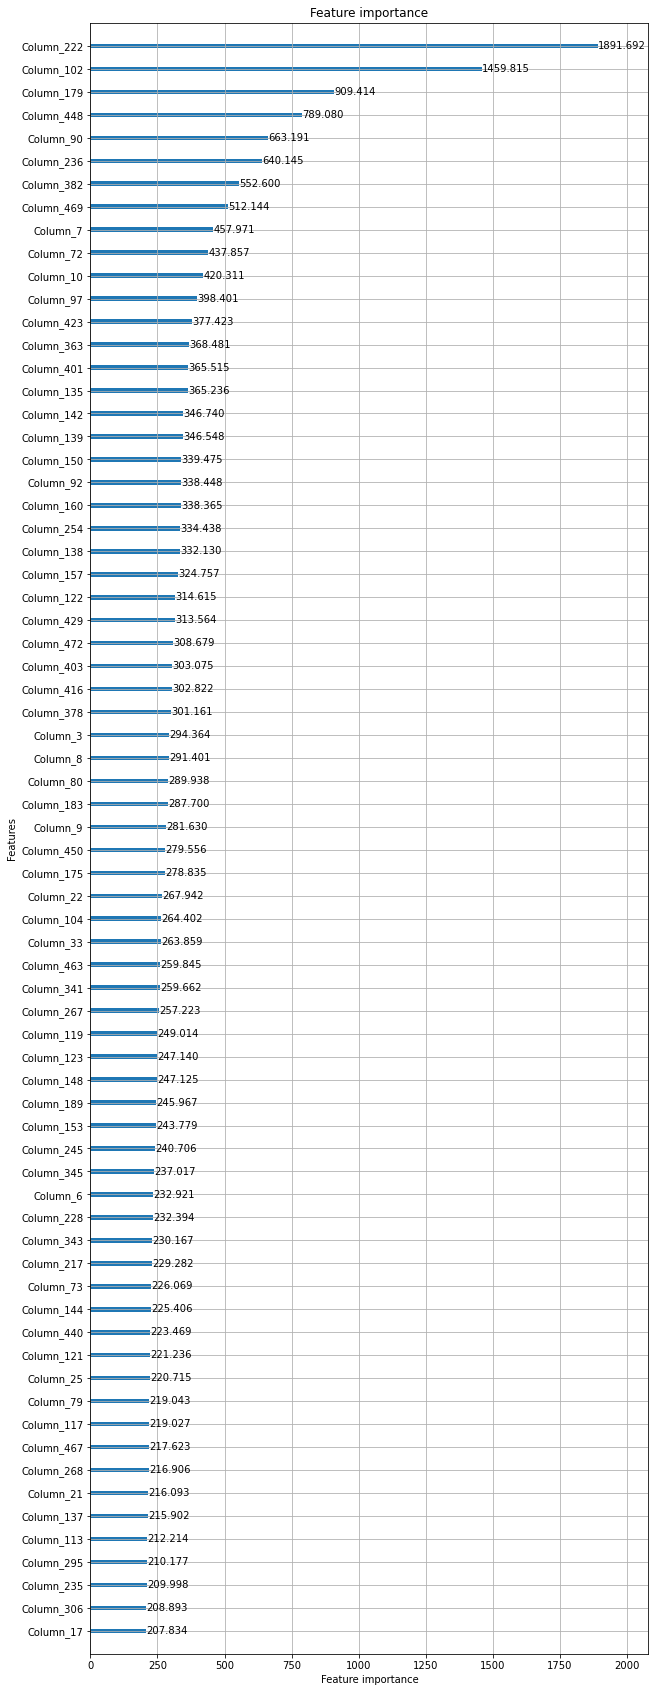

In [349]:
plot_importance(lgbm, 
                importance_type='gain', 
                max_num_features=70, 
                figsize=(10, 30))

### Best modèle

- resample=`{'func': 'mean', 'unit': 'H'}`,
- slice_=`[(12, 36), (-24, None)]`
- MinMaxScaler
- LGBM `n_estimators=500, class_weight={0: 0.3, 1: 0.7}`

`0.31`

### Classification

Il faut soumettre un extracteur de caractéristiques et un classifieur. La fonction `transform` de l'extracteur de caractéristiques est exécutée sur chaque donnée d'entrée (cible, source, bkg) et les tableaux résultants sont passés aux fonctions fit et predict du classifieur.

In [53]:
trained_workflow = problem.workflow.train_submission('submissions/prepare_rf', X_train, y_train)
y_test_pred = problem.workflow.test_submission(trained_workflow, X_test)

Temps clean :  39.49433183670044
Temps prepare :  154.41123390197754
(46110, 253)


submissions/prepare_rf/feature_extractor.py:94: RuntimeWarning: Mean of empty slice
  


Temps clean :  50.07652497291565
Temps prepare :  173.56100821495056
(50862, 253)
Temps clean :  0.4492971897125244
Temps prepare :  1.6324219703674316
(438, 253)
Temps clean :  8.725809812545776
Temps prepare :  22.908020973205566
(8202, 253)
Temps clean :  29.15816903114319
Temps prepare :  82.29805588722229
(29592, 253)
LGBMClassifier(n_estimators=500, random_state=44)


submissions/prepare_rf/feature_extractor.py:94: RuntimeWarning: Mean of empty slice
  


Temps clean :  15.754160165786743
Temps prepare :  53.1059889793396
(17758, 253)
Temps clean :  50.34573221206665
Temps prepare :  162.23746609687805
(47275, 253)


### Cross validation

Nous utilisons une validation croisée dix fois (stratifiée lorsque les étiquettes sont disponibles) pour tous les ensembles de données. Dans chaque split, 20% des instances sont dans l'ensemble de validation, à l'exception des données cibles étiquetées qui servent principalement à la validation (pour obtenir une estimation non biaisée des scores de test, évalués entièrement sur des échantillons cibles étiquetés). Nous plaçons vingt points cibles étiquetés dans les splits d'entraînement. La raison en est que lorsque nous étendons nos services à large bande à la ville B, nous pouvons obtenir rapidement un petit ensemble de données étiquetées, mais nous aimerions déployer notre détecteur de défaillance sans attendre deux mois pour recueillir des données comparables à celles de la ville A.

Le schéma de validation croisée (voir `problem.get_cv`) est implémenté dans la classe `TLShuffleSplit` de `external_imports.utils.cv.py`, si vous voulez y regarder de plus près.

Vous êtes libre de jouer avec la coupure train/test et la validation croisée lors du développement de vos modèles mais sachez que nous utiliserons la même configuration sur le serveur officiel que celle du kit RAMP (sur un ensemble différent de quatre campagnes qui ne sera pas disponible pour vous).

La cellule suivante passe par les mêmes étapes que le script d'évaluation officiel (`ramp-test`).

In [ ]:
splits = problem.get_cv(X_train, y_train)

In [ ]:
splits = problem.get_cv(X_train, y_train)

y_test_preds = []
for fold_i, (train_is, valid_is) in enumerate(splits):
    trained_workflow = problem.workflow.train_submission(
        'submissions/starting_kit', X_train, y_train, train_is)
    X_fold_train = X_train.slice(train_is)
    X_fold_valid = X_train.slice(valid_is)
    
    y_train_pred = problem.workflow.test_submission(trained_workflow, X_fold_train)
    y_valid_pred = problem.workflow.test_submission(trained_workflow, X_fold_valid)
    y_test_pred = problem.workflow.test_submission(trained_workflow, X_test)
    print('-------------------------------------')
    print('training ap on fold {} = {}'.format(
        fold_i, ap(y_train.slice(train_is).target, y_train_pred[:,1])))
    print('validation ap on fold {} = {}'.format(
        fold_i, ap(y_train.slice(valid_is).target, y_valid_pred[:,1])))
    print('test ap on fold {} = {}'.format(fold_i, ap(y_test.target, y_test_pred[:,1])))
    
    y_test_preds.append(y_test_pred)

Nous calculons à la fois le score moyen du test et le score de la mise en sac de vos dix modèles. Le classement officiel sera déterminé par le score de test mis en sac (sur des ensembles de données différents de ceux dont vous disposez). Votre score public sera le score de validation mis en sac (le calcul de la moyenne est [légèrement plus compliqué](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/utils/combine.py#L56) car nous devons nous occuper correctement des masques de validation croisée). 

In [ ]:
bagged_y_pred = np.array(y_test_preds).mean(axis=0)
print('Mean ap score = {}'.format(
    np.mean([ap(y_test.target, y_test_pred[:,1]) for y_test_pred in y_test_preds])))
print('Bagged ap score = {}'.format(
    ap(y_test.target, np.array([y_test_pred for y_test_pred in y_test_preds]).mean(axis=0)[:,1])))

## Exemple submissions

Outre le kit de départ, nous vous proposons deux autres exemples de soumissions. L'extracteur de caractéristiques est le même dans les trois. `source_rf` est similaire au kit de départ, mais utilise des arbres plus nombreux et plus profonds, pour obtenir un meilleur score. `target_rf` est une autre soumission extrême qui utilise seulement l'instance d'entraînement de la cible (peu) étiquetée pour apprendre un classificateur. Il a une performance légèrement moins bonne que `source_rf` ce qui signifie que les données sources améliorent le classificateur même si les distributions sources et cibles sont différentes.

### Resultats:
|          | ap             | rec-5         | rec-10         | rec-20         | acc            |  auc           | 
|:---------|:--------------:|:-------------:|:--------------:|:--------------:|:--------------:|:--------------:|   
|source_rf | 0.191 ± 0.0026 | 0.073 ± 0.002 | 0.176 ± 0.0032 | 0.357 ± 0.0075 | 0.84 ± 0.0014  | 0.637 ± 0.0063 | 
|target_rf | 0.163 ± 0.0218 | 0.067 ± 0.0182| 0.138 ± 0.0339 | 0.272 ± 0.0537 | 0.813 ± 0.036  | 0.591 ± 0.0399 | 

La grande question de l'apprentissage par transfert à résoudre est la suivante : **Comment combiner les données cibles à faible biais et à haute variance avec les données sources à faible biais et à haute variance**. D'autres questions auxquelles nous nous attendons à voir des réponses :

1. Peut-on faire un meilleur prétraitement (amputation des données manquantes, utilisation du temps d'une manière plus intelligente) dans l'extracteur de caractéristiques ?
2. Normalement, les données d'arrière-plan (bonnes instances) ne participent pas au scoring, mais elles peuvent informer le classifieur du changement de distribution. Comment utiliser au mieux cette information ?

## Local testing (before submission)

In [ ]:
!ramp-test --submission prepare_rf

Testing Optical access network failure prediction
Reading train and test files from ./data/ ...
Train data
Optical Dataset composed of
46110 source samples
50862 source background samples
438 target labeled samples
8202 target unlabeled samples
29592 target background samples
 Optical Dataset labels composed of
46110 labels of source samples
438 labels of target samples

Test data
Optical Dataset composed of
0 source samples
0 source background samples
17758 target labeled samples
0 target unlabeled samples
47275 target background samples
 Optical Dataset labels composed of
0 labels of source samples
17758 labels of target samples

Train data


If you want to have a local leaderboard, use the `--save-output` option when running `ramp-test`, then try `ramp-show leaderboard` with different options. For example:
```
ramp-show leaderboard --mean --metric "['ap','auc']" --step "['valid','test']" --precision 3
```
and
```
ramp-show leaderboard --bagged --metric "['auc']"
```

RAMP also has an experimental hyperopt feature, with random grid search implemented. If you want to use it, type
```
ramp-hyperopt --help
```
and check out the example submission [here](https://github.com/ramp-kits/titanic/tree/hyperopt/submissions/starting_kit_h).